# Project Histology Tissue Classification Project - Selection of models

## Import needed packages

In [166]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import pickle
import shutil
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.callbacks import ModelCheckpoint

In [2]:
tf.__version__

'1.12.0'

## Loading the data

### Loading the data from pickle files

In [11]:
x_train=pickle.load(open('./data/x_train.pkl', 'rb'))
x_test=pickle.load(open('./data/x_test.pkl', 'rb'))
x_val=pickle.load(open('./data/x_val.pkl', 'rb'))

In [12]:
y_train=pickle.load(open('./data/y_train.pkl', 'rb'))
y_test=pickle.load(open('./data/y_test.pkl', 'rb'))
y_val=pickle.load(open('./data/y_val.pkl', 'rb'))

### Basics checks

In [13]:
print('1- Training set:', x_train.shape, y_train.shape)
print('2- Validation set:', x_val.shape, y_val.shape)
print('3- Testing set:', x_test.shape, y_test.shape)

1- Training set: (3000, 150, 150, 3) (3000, 8)
2- Validation set: (1000, 150, 150, 3) (1000, 8)
3- Testing set: (1000, 150, 150, 3) (1000, 8)


In [14]:
np.amin(x_train), np.amin(x_test), np.amin(x_val)

(0.0, 0.0, 0.0)

In [15]:
np.amax(x_train), np.amax(x_test), np.amax(x_val)

(1.0, 1.0, 1.0)

## Building models

### Defining the input shape

In [18]:
(x_train.shape[1],x_train.shape[2],x_train.shape[3])

(150, 150, 3)

In [19]:
input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])

In [20]:
input_shape

(150, 150, 3)

### Define plot style

In [31]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [34]:
plt.style.use('seaborn-ticks')

In [161]:
def plot_acc_loss(history):
    # plot the training loss and accuracy
    fig = plt.figure(figsize=(9, 3), dpi=100)
    plt.subplots_adjust(wspace = 0.6 )
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(np.arange(0, EPOCHS), history.history['acc'], 'b', label='training accuracy')
    ax1.plot(np.arange(0, EPOCHS), history.history['val_acc'], 'r', label='validation accuracy');
    ax1.set_title('Accuracy')
    ax1.set_xlabel("Number of epoch ")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="best")


    ax2.plot(np.arange(0, EPOCHS), history.history["loss"], label="training loss")
    ax2.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="validation loss")
    ax2.set_title("Loss")
    ax2.set_xlabel("Number of epoch ")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="best");
    
    print('Loss:')
    print('  - loss [training dataset]: {0:.3f}'.format(history.history['loss'][-1]))
    print('  - loss [validation dataset: {0:.3f}'.format(history.history['val_loss'][-1]))
    print('')
    print('Accuracy:')
    print('  - accuracy [training dataset]: {:.2f}%'.format(100*history.history['acc'][-1]))
    print('  - accuracy [validation dataset: {:.2f}%'.format(100*history.history['val_acc'][-1]))

### CNN model v1

In [174]:
def model_cnn_v1():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 3, 3, input_shape=input_shape))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    #model.add(tf.keras.layers.Conv2D(32, 3, 3))
    #model.add(tf.keras.layers.Activation('relu'))
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, 3, 3))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Activation('sigmoid'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v1=model_cnn_v1()

# take a look at the model summary
model_cnn_v1.summary()

# save weight before training
initial_weights = model_cnn_v1.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
__________

In [175]:
# set to the original weights for testing other pipelines
model_cnn_v1.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v1.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=100
BATCH_SIZE=256
#BATCH_SIZE=128
#BATCH_SIZE=64

history=model_cnn_v1.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])
%time

Train on 3000 samples, validate on 1000 samples
Epoch 1/100
2816/3000 [===========================>..] - ETA: 0s - loss: 2.0293 - acc: 0.1932
Epoch 00001: val_loss improved from inf to 1.90073, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 7s 2ms/step - loss: 2.0253 - acc: 0.1967 - val_loss: 1.9007 - val_acc: 0.3520
Epoch 2/100
2816/3000 [===========================>..] - ETA: 0s - loss: 1.8142 - acc: 0.2610
Epoch 00002: val_loss improved from 1.90073 to 1.59472, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 1.8065 - acc: 0.2603 - val_loss: 1.5947 - val_acc: 0.3380
Epoch 3/100
2816/3000 [===========================>..] - ETA: 0s - loss: 1.6232 - acc: 0.2820
Epoch 00003: val_loss improved from 1.59472 to 1.50014, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 1.6209 - acc: 0.2833 - v

Epoch 27/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.9014 - acc: 0.5604
Epoch 00027: val_loss did not improve from 0.80403
3000/3000 [==============================] - 5s 2ms/step - loss: 0.8989 - acc: 0.5597 - val_loss: 0.8420 - val_acc: 0.5520
Epoch 28/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.8836 - acc: 0.5597
Epoch 00028: val_loss improved from 0.80403 to 0.79830, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.8884 - acc: 0.5567 - val_loss: 0.7983 - val_acc: 0.5550
Epoch 29/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.8840 - acc: 0.5664
Epoch 00029: val_loss did not improve from 0.79830
3000/3000 [==============================] - 5s 2ms/step - loss: 0.8849 - acc: 0.5673 - val_loss: 0.8110 - val_acc: 0.5520
Epoch 30/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.8846 - acc: 0.5721
Epoch 00030: val_loss did not improv

Epoch 55/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6691 - acc: 0.7301
Epoch 00055: val_loss improved from 0.62155 to 0.61140, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6712 - acc: 0.7307 - val_loss: 0.6114 - val_acc: 0.7730
Epoch 56/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6844 - acc: 0.7401
Epoch 00056: val_loss did not improve from 0.61140
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6799 - acc: 0.7440 - val_loss: 0.6435 - val_acc: 0.7570
Epoch 57/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6628 - acc: 0.7457
Epoch 00057: val_loss improved from 0.61140 to 0.60096, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6630 - acc: 0.7467 - val_loss: 0.6010 - val_acc: 0.7720
Epoch 58/100
2816/3000 [===========================>..] - ETA: 0s - l

2816/3000 [===========================>..] - ETA: 0s - loss: 0.5677 - acc: 0.7820
Epoch 00084: val_loss did not improve from 0.56695
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5710 - acc: 0.7797 - val_loss: 0.6074 - val_acc: 0.7630
Epoch 85/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.5817 - acc: 0.7727
Epoch 00085: val_loss did not improve from 0.56695
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5790 - acc: 0.7740 - val_loss: 0.5987 - val_acc: 0.7760
Epoch 86/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.5780 - acc: 0.7706
Epoch 00086: val_loss did not improve from 0.56695
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5781 - acc: 0.7697 - val_loss: 0.5861 - val_acc: 0.7710
Epoch 87/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.5663 - acc: 0.7756
Epoch 00087: val_loss did not improve from 0.56695
3000/3000 [==============================] - 5s 2ms/step - l

Loss:
  - loss [training dataset]: 0.541
  - loss [validation dataset: 0.610

Accuracy:
  - accuracy [training dataset]: 78.23%
  - accuracy [validation dataset: 76.60%


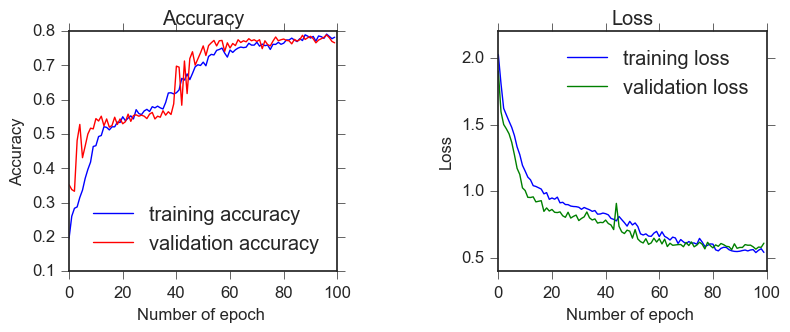

In [176]:
plot_acc_loss(history)

### CNN model v2

In [180]:
def model_cnn_v2():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256,activation = "relu"))          
    model.add(tf.keras.layers.Dense(64,activation = "relu"))
    model.add(tf.keras.layers.Dense(32,activation = "relu"))

    model.add(tf.keras.layers.Dense(8, activation = "softmax"))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v2=model_cnn_v2()

# take a look at the model summary
model_cnn_v2.summary()

# save weight before training
initial_weights = model_cnn_v2.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
__________

In [183]:
# set to the original weights for testing other pipelines
model_cnn_v2.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v2.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=50
#BATCH_SIZE=256
#BATCH_SIZE=128
BATCH_SIZE=64

history=model_cnn_v2.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])
%time

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
2944/3000 [============================>.] - ETA: 6s - loss: 1.7105 - acc: 0.2812 
Epoch 00001: val_loss improved from inf to 1.60882, saving model to ./results/model_cnn_v2.weights.best.hdf5
3000/3000 [==============================] - 383s 128ms/step - loss: 1.6989 - acc: 0.2833 - val_loss: 1.6088 - val_acc: 0.3690
Epoch 2/50
2944/3000 [============================>.] - ETA: 6s - loss: 1.1224 - acc: 0.4786 
Epoch 00002: val_loss improved from 1.60882 to 0.93550, saving model to ./results/model_cnn_v2.weights.best.hdf5
3000/3000 [==============================] - 380s 127ms/step - loss: 1.1177 - acc: 0.4817 - val_loss: 0.9355 - val_acc: 0.5940
Epoch 3/50
2944/3000 [============================>.] - ETA: 6s - loss: 0.9435 - acc: 0.5730 
Epoch 00003: val_loss did not improve from 0.93550
3000/3000 [==============================] - 377s 126ms/step - loss: 0.9406 - acc: 0.5750 - val_loss: 0.9471 - val_acc: 0.5950
Epoch 4/50
2944/

Epoch 30/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0902 - acc: 0.9708 
Epoch 00030: val_loss did not improve from 0.62846
3000/3000 [==============================] - 338s 113ms/step - loss: 0.0887 - acc: 0.9713 - val_loss: 1.1311 - val_acc: 0.7690
Epoch 31/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0495 - acc: 0.9830 
Epoch 00031: val_loss did not improve from 0.62846
3000/3000 [==============================] - 336s 112ms/step - loss: 0.0488 - acc: 0.9833 - val_loss: 1.1020 - val_acc: 0.7720
Epoch 32/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0683 - acc: 0.9786 
Epoch 00032: val_loss did not improve from 0.62846
3000/3000 [==============================] - 336s 112ms/step - loss: 0.0677 - acc: 0.9787 - val_loss: 1.1498 - val_acc: 0.7790
Epoch 33/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0762 - acc: 0.9738 
Epoch 00033: val_loss did not improve from 0.62846
3000/3000 [========================

Loss:
  - loss [training dataset]: 0.046
  - loss [validation dataset: 0.951

Accuracy:
  - accuracy [training dataset]: 98.87%
  - accuracy [validation dataset: 78.70%


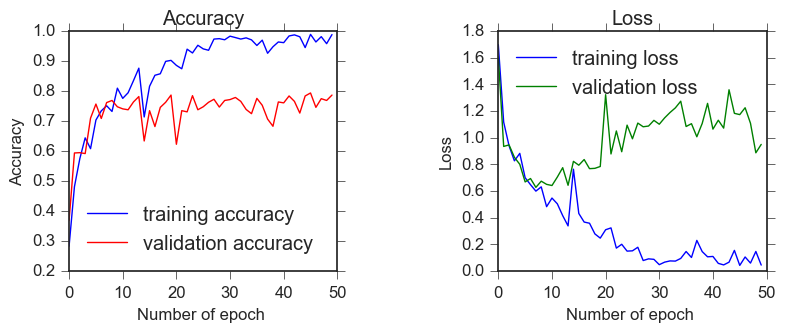

In [184]:
plot_acc_loss(history)

### CNN model v3

In [185]:
def model_cnn_v3():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.Dense(8, activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v3=model_cnn_v3()

# take a look at the model summary
model_cnn_v3.summary()

# save weight before training
initial_weights = model_cnn_v3.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
__________

In [ ]:
# set to the original weights for testing other pipelines
model_cnn_v3.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v3.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=50
#BATCH_SIZE=256
#BATCH_SIZE=128
BATCH_SIZE=64

history=model_cnn_v3.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])
%time

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
 960/3000 [========>.....................] - ETA: 1:30 - loss: 1.8520 - acc: 0.2375

### Model 4

In [422]:
#Load the VGG model
vgg_conv = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

In [423]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x45f93a550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45f93a240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45f962ac8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x456374a20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45f962550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45e1b47b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x45e1ceeb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45fb8d9e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x45fbacc18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x2000f5710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x200129dd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x200108f98> False
<tensorflow.py

In [424]:
# Create the model
model = tf.keras.models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

In [425]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [426]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

In [427]:
EPOCHS=10
#BATCH_SIZE=256
BATCH_SIZE=128
#BATCH_SIZE=64

In [428]:
history=model.fit(x_train,
                  y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_test, y_test),
                  callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
2944/3000 [============================>.] - ETA: 12s - loss: 1.9755 - acc: 0.2755
Epoch 00001: val_loss improved from inf to 1.68525, saving model to model.weights.best.hdf5
3000/3000 [==============================] - 878s 293ms/step - loss: 1.9679 - acc: 0.2767 - val_loss: 1.6853 - val_acc: 0.3040
Epoch 2/10
2944/3000 [============================>.] - ETA: 12s - loss: 1.4988 - acc: 0.3577
Epoch 00002: val_loss improved from 1.68525 to 1.50649, saving model to model.weights.best.hdf5
3000/3000 [==============================] - 882s 294ms/step - loss: 1.4948 - acc: 0.3590 - val_loss: 1.5065 - val_acc: 0.3970
Epoch 3/10
2944/3000 [============================>.] - ETA: 12s - loss: 1.3013 - acc: 0.4606
Epoch 00003: val_loss improved from 1.50649 to 1.07579, saving model to model.weights.best.hdf5
3000/3000 [==============================] - 876s 292ms/step - loss: 1.2987 - acc: 0.4603 - val_loss: 1.0758 - val_acc: 0.5680
Epoch

In [433]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5134660834074021
Test accuracy: 0.831


In [436]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.26766909344991047
Train accuracy: 0.9070000001589458


## Load Model with the best validation accuracy

In [437]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [438]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('Test accuracy:', score[1])

Test accuracy: 0.823


## Visualize prediction

In [439]:
y_hat = model.predict(x_test)

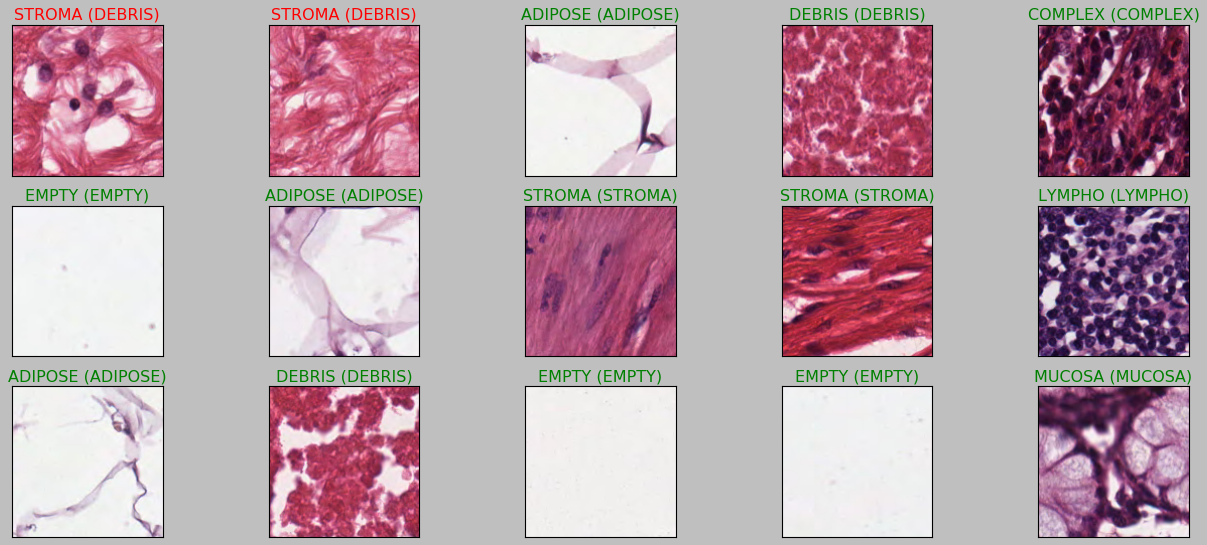

In [440]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(dict_label[predict_index], 
                                  dict_label[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

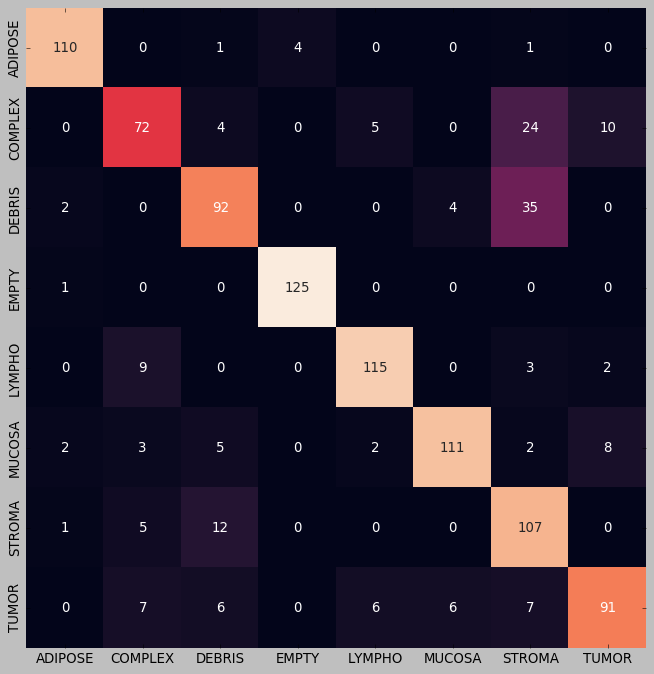

In [441]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
predict_index = np.argmax(y_hat, axis = 1)
true_index = np.argmax(y_test, axis = 1)
sns.heatmap(confusion_matrix(true_index, predict_index), 
            annot=True, cbar=False, fmt='d', ax=ax)
ax.set_yticklabels(dict_label, minor=False)
ax.set_xticklabels(dict_label, minor=False);

In [442]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label');
    plt.xlabel('Predicted label');

In [443]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(true_index, predict_index)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[110   0   1   4   0   0   1   0]
 [  0  72   4   0   5   0  24  10]
 [  2   0  92   0   0   4  35   0]
 [  1   0   0 125   0   0   0   0]
 [  0   9   0   0 115   0   3   2]
 [  2   3   5   0   2 111   2   8]
 [  1   5  12   0   0   0 107   0]
 [  0   7   6   0   6   6   7  91]]


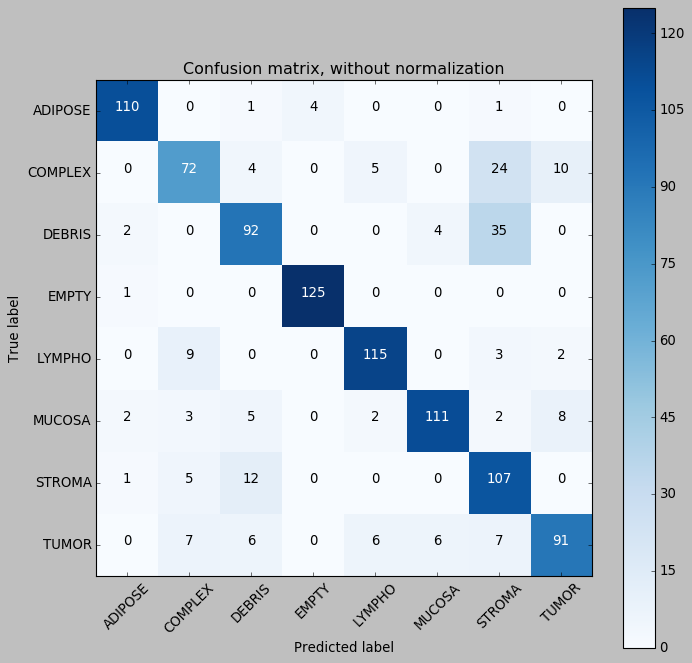

In [444]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.95 0.   0.01 0.03 0.   0.   0.01 0.  ]
 [0.   0.63 0.03 0.   0.04 0.   0.21 0.09]
 [0.02 0.   0.69 0.   0.   0.03 0.26 0.  ]
 [0.01 0.   0.   0.99 0.   0.   0.   0.  ]
 [0.   0.07 0.   0.   0.89 0.   0.02 0.02]
 [0.02 0.02 0.04 0.   0.02 0.83 0.02 0.06]
 [0.01 0.04 0.1  0.   0.   0.   0.86 0.  ]
 [0.   0.06 0.05 0.   0.05 0.05 0.06 0.74]]


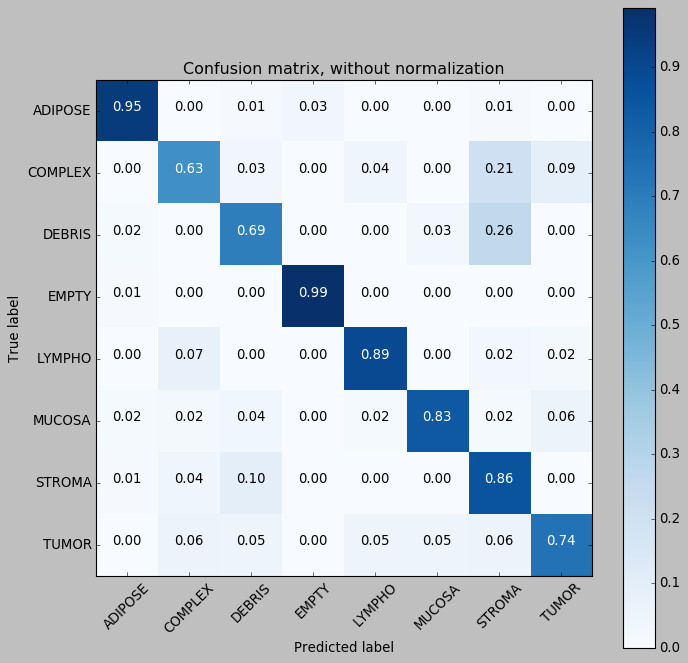

In [445]:
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,normalize=True,
                      title='Confusion matrix, without normalization')